In [43]:
from pymongo import MongoClient
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, confusion_matrix, classification_report
from bson import ObjectId
import random
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from dotenv import load_dotenv

# Load environment variables
load_dotenv()
mongo_uri = os.getenv('MONGO_URI')
client = MongoClient(mongo_uri)
db = client[os.getenv('MONGO_DB_NAME')]

# Define collections
users_collection = db['users']
posts_collection = db['posts']
likes_collection = db['likes']
answers_collection = db['answers']

# Fetch data from MongoDB
users = list(users_collection.find())
posts = list(posts_collection.find())
likes = list(likes_collection.find())
answers = list(answers_collection.find())

# Create mappings for user and post IDs
user_ids = {str(user['_id']): idx for idx, user in enumerate(users)}
post_ids = {str(post['_id']): idx for idx, post in enumerate(posts)}
post_topics = {str(post['_id']): post['topic'] for post in posts}

num_users = len(users)
num_posts = len(posts)
ratings_matrix = np.zeros((num_users, num_posts))

# Populate ratings matrix with likes and answers
for like in likes + answers:
    user_id_str = str(like['user_id'])
    post_id_str = str(like['post_id'])

    if user_id_str in user_ids and post_id_str in post_ids:
        user_idx = user_ids[user_id_str]
        post_idx = post_ids[post_id_str]
        ratings_matrix[user_idx, post_idx] = 1

# Initialize user-topic preferences
user_topic_preferences = {user_idx: {} for user_idx in range(num_users)}

# Normalize topic preferences
for user_idx in user_topic_preferences:
    total_likes = sum(user_topic_preferences[user_idx].values())
    for topic in user_topic_preferences[user_idx]:
        user_topic_preferences[user_idx][topic] /= total_likes if total_likes > 0 else 1

In [44]:
def predict_rating(user_idx, post_idx, train_matrix, user_similarity):
    """
    Predict rating for a given user and post based on user similarity scores.
    """
    sim_scores = user_similarity[user_idx]
    item_ratings = train_matrix[:, post_idx]
    non_zero_ratings = item_ratings[item_ratings != 0]

    weighted_sum = 0
    similarity_sum = 0
    for idx in range(len(non_zero_ratings)):
        similarity = sim_scores[idx]
        weighted_sum += similarity * item_ratings[idx]
        similarity_sum += similarity

    if similarity_sum == 0:
        return 0
    return weighted_sum / similarity_sum

def create_train_test_split(ratings_matrix, test_size=0.2):
    """
    Create train and test splits from the ratings matrix.
    """
    num_users, num_posts = ratings_matrix.shape
    train_matrix = np.copy(ratings_matrix)
    test_matrix = np.zeros_like(ratings_matrix)

    for user in range(num_users):
        non_zero_indices = np.nonzero(ratings_matrix[user])[0]
        if len(non_zero_indices) < 2:
            continue

        train_indices, test_indices = train_test_split(non_zero_indices, test_size=test_size, random_state=42)
        train_matrix[user, train_indices] = ratings_matrix[user, train_indices]
        test_matrix[user, test_indices] = ratings_matrix[user, test_indices]

    return train_matrix, test_matrix


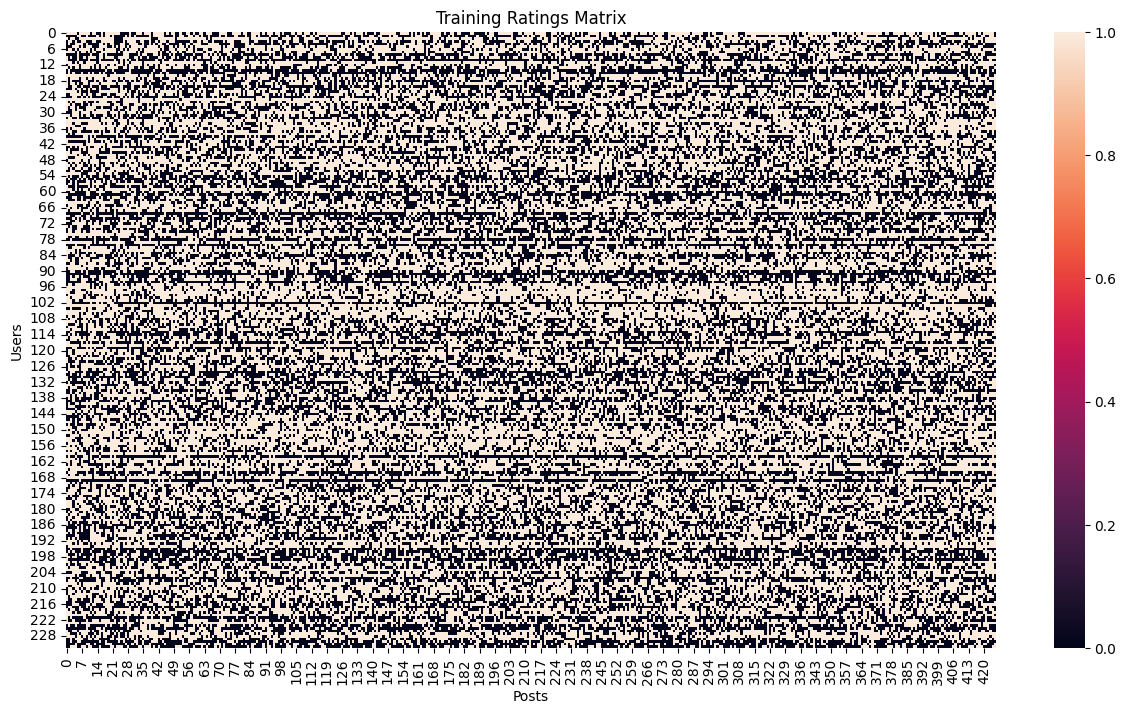

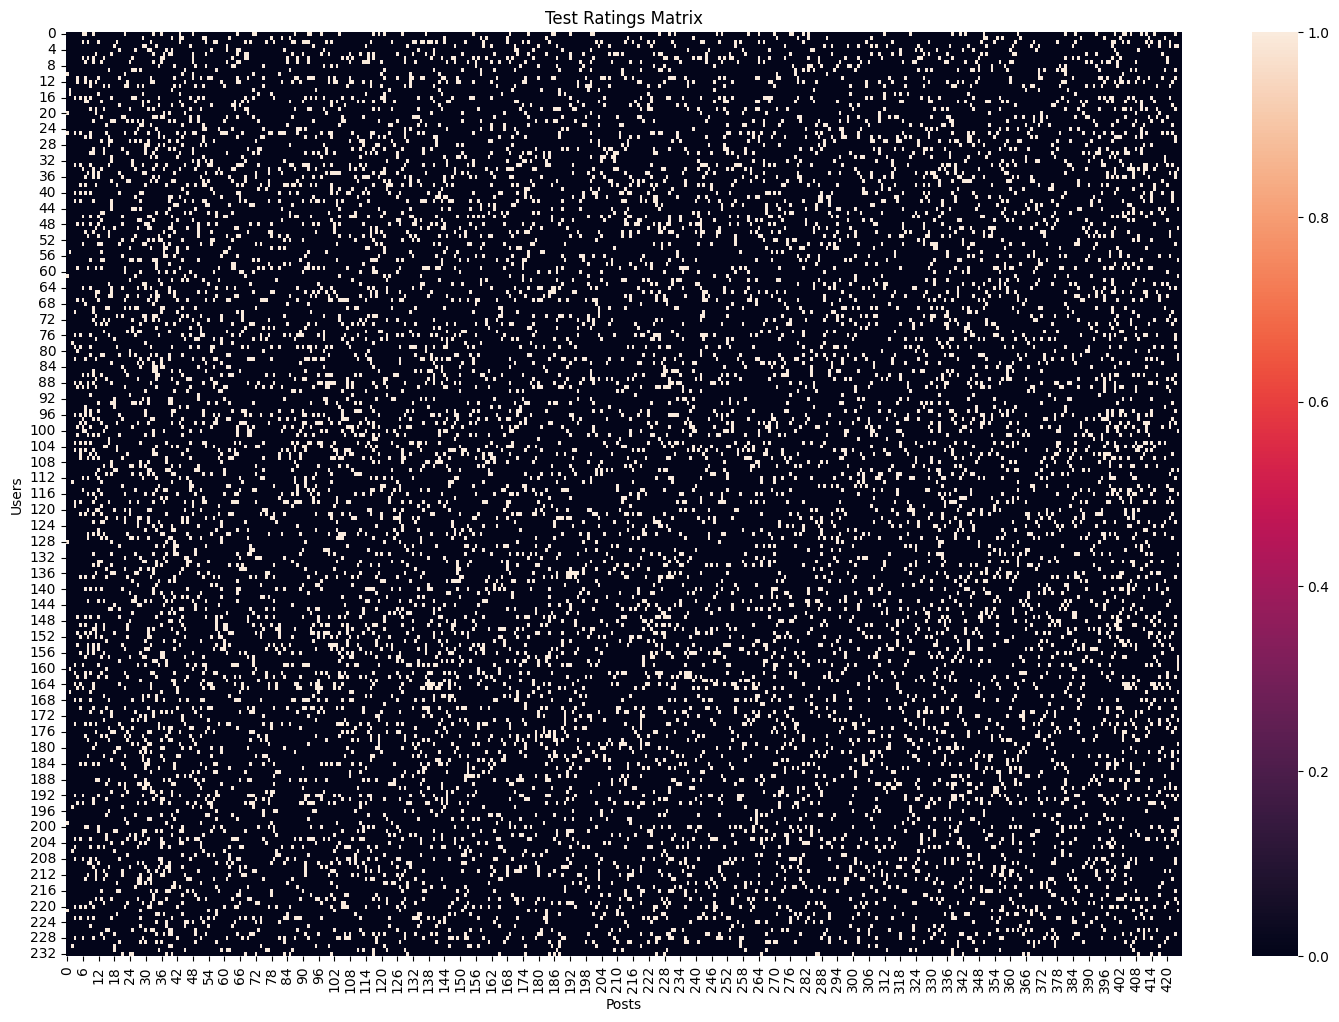

In [45]:
train_matrix, test_matrix = create_train_test_split(ratings_matrix, test_size=0.2)

# Visualize the ratings matrix
plt.figure(figsize=(15, 8))
sns.heatmap(train_matrix)
plt.title('Training Ratings Matrix')
plt.xlabel('Posts')
plt.ylabel('Users')
plt.show()

plt.figure(figsize=(18, 12))
sns.heatmap(test_matrix)
plt.title('Test Ratings Matrix')
plt.xlabel('Posts')
plt.ylabel('Users')
plt.show()

def recommend_posts(user_idx, train_matrix, user_similarity, user_topic_preferences, num_recommendations=5):
    """
    Recommend posts for a given user based on similar users' likes and topic preferences.
    """
    sim_scores = user_similarity[user_idx]
    similar_users = np.argsort(sim_scores)[::-1][1:]  # Exclude the user itself

    post_scores = np.zeros(train_matrix.shape[1])
    for similar_user in similar_users:
        post_scores += sim_scores[similar_user] * train_matrix[similar_user]

    for post_idx in range(train_matrix.shape[1]):
        post_id_str = list(post_ids.keys())[post_idx]
        topic = post_topics[post_id_str]
        if topic in user_topic_preferences[user_idx]:
            post_scores[post_idx] *= (1 + user_topic_preferences[user_idx][topic])

    post_scores[train_matrix[user_idx] > 0] = 0  # Exclude already liked posts
    recommended_post_indices = np.argsort(post_scores)[::-1][:num_recommendations]
    return recommended_post_indices

In [46]:
def evaluate_model(test_matrix, train_matrix, user_similarity):
    """
    Evaluate the model using Mean Absolute Error and classification metrics.
    """
    actual_ratings = []
    predicted_ratings = []

    for user_idx in range(len(test_matrix)):
        for post_idx in range(test_matrix.shape[1]):
            if test_matrix[user_idx, post_idx] != 0:
                actual_ratings.append(test_matrix[user_idx, post_idx])
                predicted_ratings.append(predict_rating(user_idx, post_idx, train_matrix, user_similarity))

    if not actual_ratings or not predicted_ratings:
        print("Warning: One or both arrays are empty.")
        return

    # Convert to binary format
    threshold = 0.5
    binary_predictions = [1 if p >= threshold else 0 for p in predicted_ratings]
    binary_actuals = [1 if a >= threshold else 0 for a in actual_ratings]

    # Calculate metrics
    mae = mean_absolute_error(binary_actuals, binary_predictions)
    conf_matrix = confusion_matrix(binary_actuals, binary_predictions)
    class_report = classification_report(binary_actuals, binary_predictions, output_dict=True, zero_division=0)

    # Visualize confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Liked', 'Liked'], yticklabels=['Not Liked', 'Liked'])
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

    # Display classification report and MAE
    print("Classification Report:")
    print(classification_report(binary_actuals, binary_predictions, zero_division=0))
    print(f'Mean Absolute Error: {mae}')
    
    precision = class_report['1']['precision']
    recall = class_report['1']['recall']
    f1 = class_report['1']['f1-score']

    print(f'Precision: {precision}')
    print(f'Recall: {recall}')
    print(f'F1 Score: {f1}')

In [47]:
def train_model():
    """
    Train the recommendation model, generate recommendations, and evaluate performance.
    """


    # Calculate cosine similarity between users
    user_similarity = cosine_similarity(train_matrix)
    print('------------------------------------------------------')
    print('user similarity shape: ', user_similarity.shape)
    print('user similarity: ', user_similarity)
    print('------------------------------------------------------')

    # Visualize the user similarity matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(user_similarity)
    plt.title('User Similarity Matrix')
    plt.xlabel('Users')
    plt.ylabel('Users')
    plt.show()

    # Generate recommendations
    recommendations = {}
    for user_id_str, user_idx in user_ids.items():
        if user_idx >= user_similarity.shape[0]:
            continue
        recommended_posts = recommend_posts(user_idx, train_matrix, user_similarity, user_topic_preferences, num_recommendations=5)
        recommended_post_ids = [list(post_ids.keys())[post_idx] for post_idx in recommended_posts]
        recommendations[user_id_str] = recommended_post_ids

    # Save recommendations to a JSON file
    with open('recommendations.json', 'w') as f:
        json.dump(recommendations, f)

    # Evaluate model
    evaluate_model(test_matrix, train_matrix, user_similarity)

    return train_matrix, recommendations, user_similarity

------------------------------------------------------
user similarity shape:  (233, 233)
user similarity:  [[1.         0.53262027 0.73974688 ... 0.45112045 0.46589595 0.49485419]
 [0.53262027 1.         0.53680727 ... 0.32620012 0.37891502 0.38245627]
 [0.73974688 0.53680727 1.         ... 0.49737403 0.5497625  0.54018991]
 ...
 [0.45112045 0.32620012 0.49737403 ... 1.         0.2815595  0.29971167]
 [0.46589595 0.37891502 0.5497625  ... 0.2815595  1.         0.36462072]
 [0.49485419 0.38245627 0.54018991 ... 0.29971167 0.36462072 1.        ]]
------------------------------------------------------


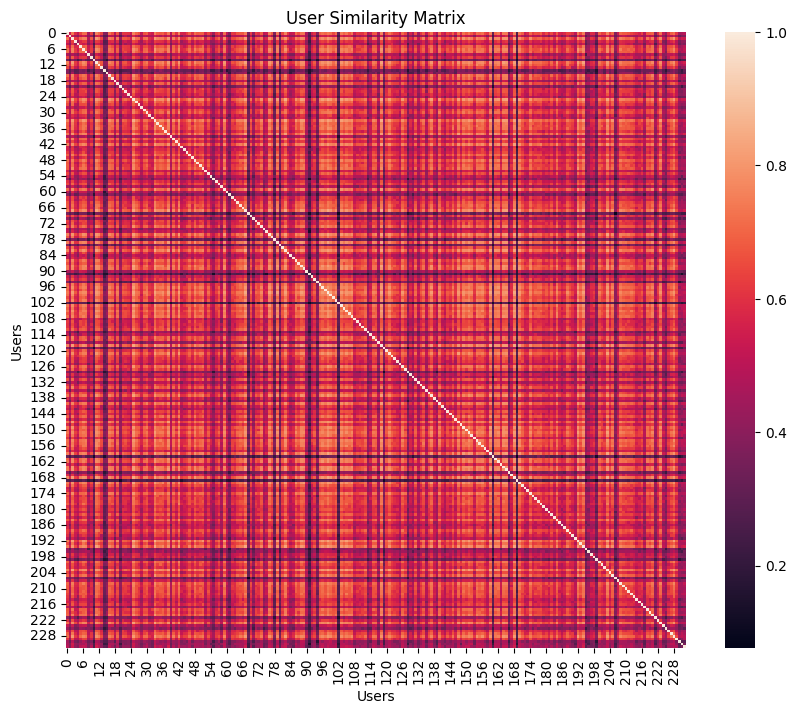

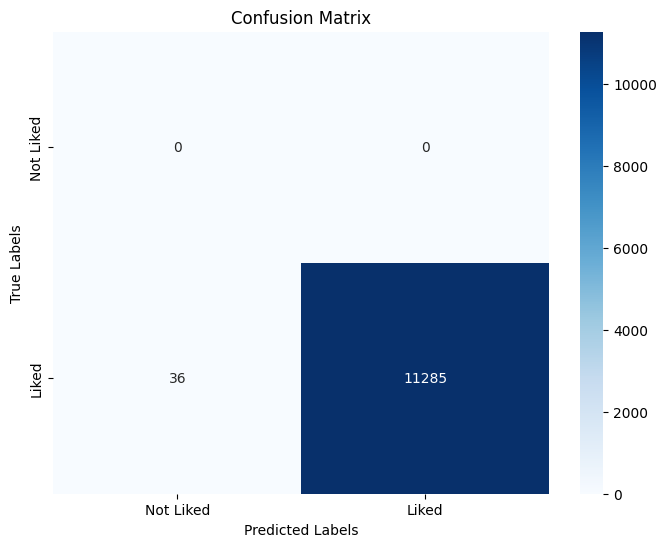

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      1.00      1.00     11321

    accuracy                           1.00     11321
   macro avg       0.50      0.50      0.50     11321
weighted avg       1.00      1.00      1.00     11321

Mean Absolute Error: 0.003179931101492801
Precision: 1.0
Recall: 0.9968200688985072
F1 Score: 0.9984075024329824
                    User_ID          Recommendation_1  \
0  669c0b8e2ea43ac3b0c83bd2  66a7ed8ed84c8562211dc679   
1  669c0b8e2ea43ac3b0c83bd3  66a7ed8ed84c8562211dc785   
2  669c0b8e2ea43ac3b0c83bd4  66a7ed8ed84c8562211dc712   
3  669c0b8e2ea43ac3b0c83bd5  66a7ed8ed84c8562211dc6e6   
4  669c0b8e2ea43ac3b0c83bd6  66a7ed8ed84c8562211dc6cc   

           Recommendation_2          Recommendation_3  \
0  66a7ed8ed84c8562211dc71c  66a7ed8ed84c8562211dc6ad   
1  66a7ed8ed84c8562211dc712  66a7ed8ed84c8562211dc679   
2  66a7ed8ed84c8562211d

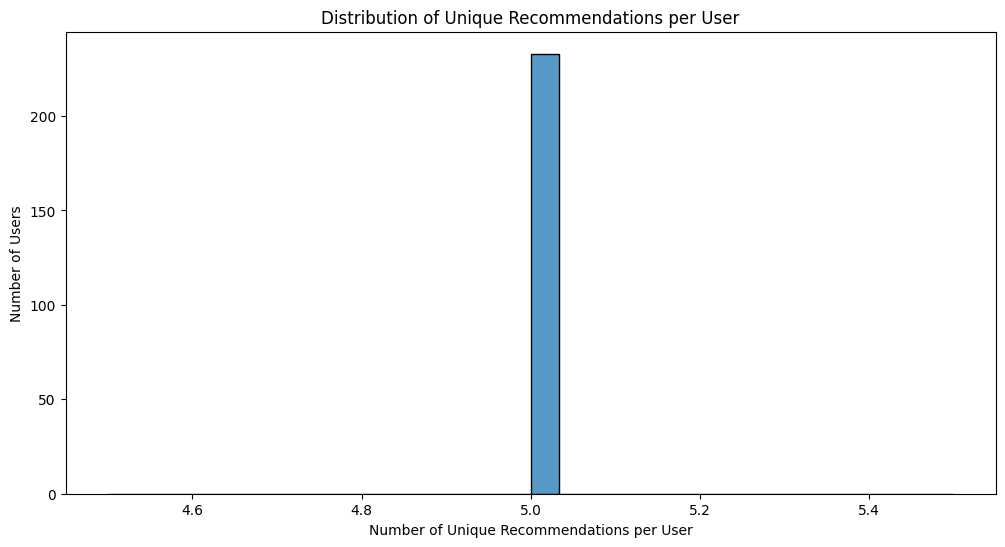

Recommendations for user 66a92a53ff9e67d72dddb6ea: ['66a7ed8ed84c8562211dc6cc', '66a7ed8ed84c8562211dc679', '66a7ed8ed84c8562211dc71c', '66a7ed8ed84c8562211dc6d5', '66a7ed8ed84c8562211dc694']
Recommendations for user 669c0b8e2ea43ac3b0c83be4: ['66a7ed8ed84c8562211dc6e6', '66a7ed8ed84c8562211dc740', '66a7ed8ed84c8562211dc6ad', '66a7ed8ed84c8562211dc78f', '66a7ed8ed84c8562211dc736']
Recommendations for user 66a92a53ff9e67d72dddb719: ['66a7ed8dd84c8562211dc602', '66a7ed8ed84c8562211dc6e2', '66a7ed8ed84c8562211dc749', '66a7ed8ed84c8562211dc765', '66a7ed8ed84c8562211dc676']
Recommendations for user 66a92a53ff9e67d72dddb6d6: ['66a7ed8ed84c8562211dc785', '66a7ed8ed84c8562211dc6cc', '66a7ed8dd84c8562211dc604', '66a7ed8ed84c8562211dc799', '66a7ed8ed84c8562211dc6fc']
Recommendations for user 66a92a53ff9e67d72dddb6da: ['66a7ed8ed84c8562211dc6e6', '66a7ed8ed84c8562211dc740', '66a7ed8ed84c8562211dc6cc', '66a7ed8ed84c8562211dc712', '66a7ed8ed84c8562211dc710']


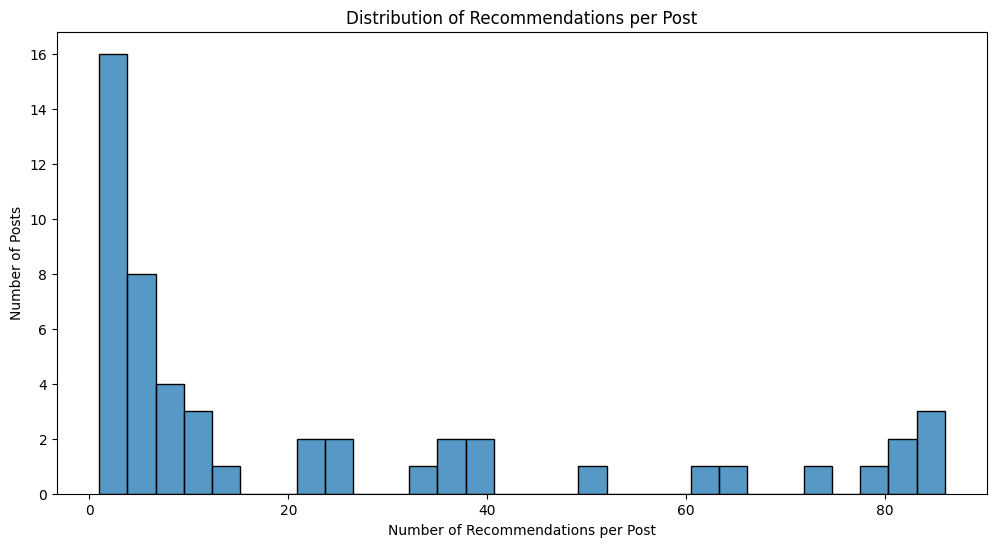

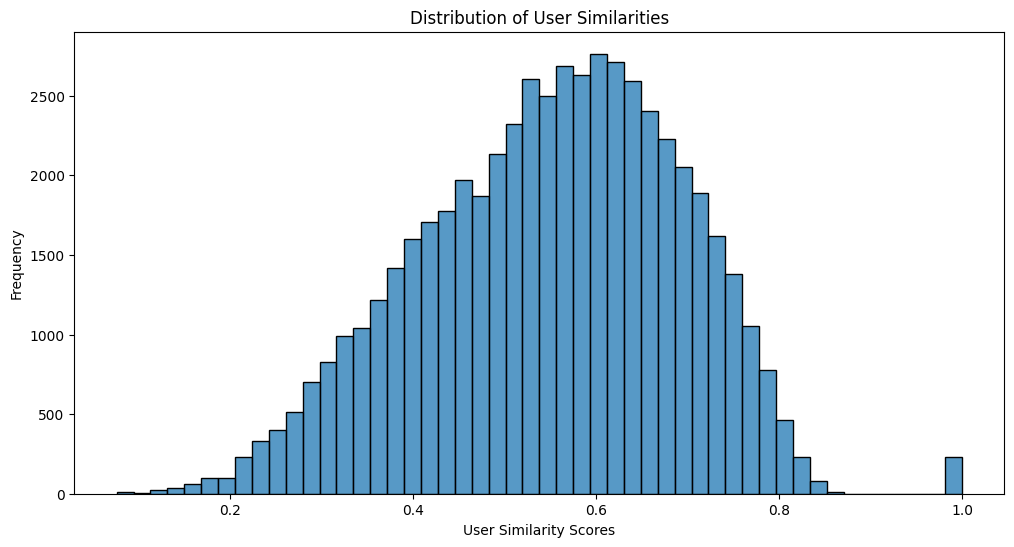

Model Training and Evaluation Report
User-Post Interaction Data
Number of Users: 233
Number of Posts: 426

User Similarity
Shape: (233, 233)

Evaluation Metrics


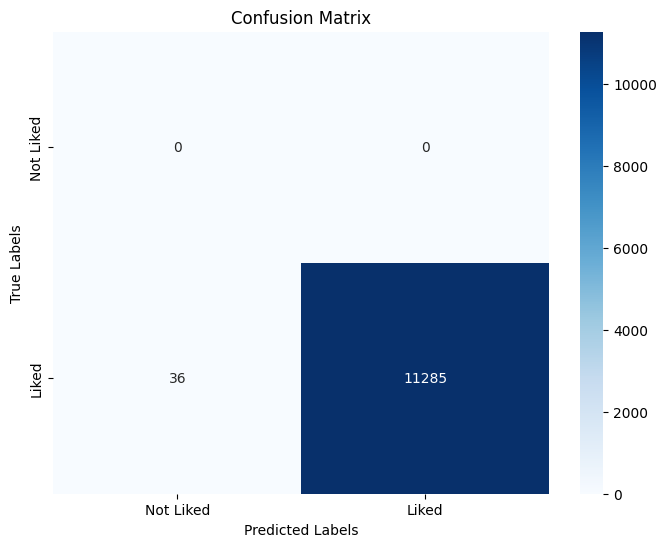

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      1.00      1.00     11321

    accuracy                           1.00     11321
   macro avg       0.50      0.50      0.50     11321
weighted avg       1.00      1.00      1.00     11321

Mean Absolute Error: 0.003179931101492801
Precision: 1.0
Recall: 0.9968200688985072
F1 Score: 0.9984075024329824

Recommendations
Number of Unique Posts Recommended: 284
Sample Recommendations:                     User_ID          Recommendation_1  \
0  669c0b8e2ea43ac3b0c83bd2  66a7ed8ed84c8562211dc679   
1  669c0b8e2ea43ac3b0c83bd3  66a7ed8ed84c8562211dc785   
2  669c0b8e2ea43ac3b0c83bd4  66a7ed8ed84c8562211dc712   
3  669c0b8e2ea43ac3b0c83bd5  66a7ed8ed84c8562211dc6e6   
4  669c0b8e2ea43ac3b0c83bd6  66a7ed8ed84c8562211dc6cc   

           Recommendation_2          Recommendation_3  \
0  66a7ed8ed84c8562211dc71c  66a7ed8ed84c8562211dc6ad   

In [48]:
train_matrix, recommendations, user_similarity = train_model()

# Load recommendations from JSON file
with open('recommendations.json', 'r') as f:
    recommendations = json.load(f)

# Convert recommendations to a pandas DataFrame for analysis
recommendations_df = pd.DataFrame.from_dict(recommendations, orient='index')
recommendations_df.columns = [f'Recommendation_{i+1}' for i in range(recommendations_df.shape[1])]
recommendations_df.reset_index(inplace=True)
recommendations_df.rename(columns={'index': 'User_ID'}, inplace=True)

# Display the first few rows of the recommendations DataFrame
print(recommendations_df.head())

# %%
def visualize_recommendations(recommendations):
    """
    Visualize recommendation distribution and post popularity.
    """
    recommendations_df = pd.DataFrame.from_dict(recommendations, orient='index')

    # Distribution of unique recommendations per user
    unique_recommendations_count = recommendations_df.apply(lambda x: len(set(x.dropna())), axis=1)
    plt.figure(figsize=(12, 6))
    sns.histplot(unique_recommendations_count, kde=False, bins=30)
    plt.xlabel('Number of Unique Recommendations per User')
    plt.ylabel('Number of Users')
    plt.title('Distribution of Unique Recommendations per User')
    plt.show()

    # Review recommendations for a few specific users
    user_sample = random.sample(list(recommendations.keys()), 5)
    for user_id in user_sample:
        print(f"Recommendations for user {user_id}: {recommendations[user_id]}")

    # Analyze post popularity in recommendations
    all_recommendations = recommendations_df.values.flatten()
    post_counts = pd.Series(all_recommendations).value_counts()
    plt.figure(figsize=(12, 6))
    sns.histplot(post_counts, bins=30, kde=False)
    plt.xlabel('Number of Recommendations per Post')
    plt.ylabel('Number of Posts')
    plt.title('Distribution of Recommendations per Post')
    plt.show()

# %%
def visualize_user_similarity(user_similarity):
    """
    Visualize the distribution of user similarities.
    """
    similarity_scores = user_similarity.flatten()
    plt.figure(figsize=(12, 6))
    sns.histplot(similarity_scores, bins=50, kde=False)
    plt.xlabel('User Similarity Scores')
    plt.ylabel('Frequency')
    plt.title('Distribution of User Similarities')
    plt.show()

# Visualize the recommendations and user similarities
visualize_recommendations(recommendations)
visualize_user_similarity(user_similarity)

# Report generation
print("Model Training and Evaluation Report")
print("="*40)
print("User-Post Interaction Data")
print(f"Number of Users: {train_matrix.shape[0]}")
print(f"Number of Posts: {train_matrix.shape[1]}")

print("\nUser Similarity")
print(f"Shape: {user_similarity.shape}")

print("\nEvaluation Metrics")
evaluate_model(test_matrix, train_matrix, user_similarity)

print("\nRecommendations")
print(f"Number of Unique Posts Recommended: {len(set(recommendations_df.values.flatten()))}")
print(f"Sample Recommendations: {recommendations_df.head()}")
